### FastAI Model

Using a pretrained deep learning model and the FastAI Framework as a starting point. This framework generally has a high accuracy, and we pick a specific pretrained model that should work well for our problem. 

***NOTE! This notebook and model training was all run on Kaggle and/or SaturnCloud with heavy GPU augmentation, and took up to two hours to run. I would recommend loading the notebooks onto SaturnCloud to run them.***

#### Imports and basic setup

In [1]:
import fastai
from fastai.vision.all import *
import pandas as pd

In [2]:
path = Path('./data')
train = pd.read_csv(path/'train.csv')
test = pd.read_csv(path/'test.csv')

#### File setup and dataloader

In [3]:
train['image'] = train['Id'].map(lambda x: f'{x:0>4}.jpg')
train.head()

,Id,label,image
0,560,glass,0560.jpg
1,4675,cup,4675.jpg
2,875,glass,0875.jpg
3,4436,spoon,4436.jpg
4,8265,plate,8265.jpg


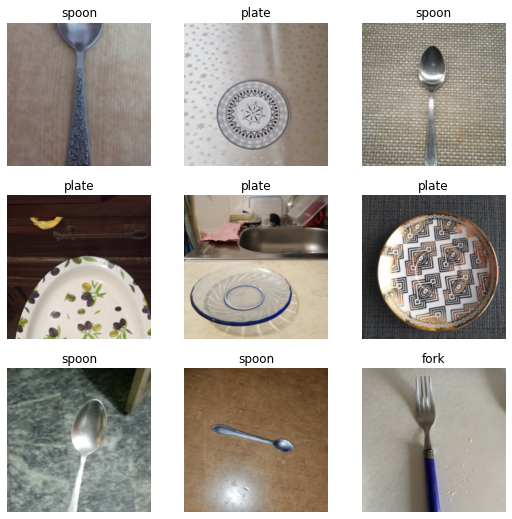

In [4]:
dataloader = ImageDataLoaders.from_df(train, path/'images', valid_pct=0.2, seed=75, fn_col='image', label_col='label', item_tfms=Resize(224))
dataloader.show_batch()

#### Model training & tuning

In [5]:
learner = vision_learner(dataloader, resnet34, metrics=accuracy, path=".")

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

SuggestedLRs(valley=0.0010000000474974513)

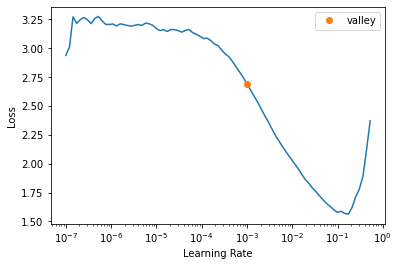

In [6]:
learner.lr_find()

In [7]:
learner.fine_tune(3, 0.0010000000474974513)

epoch,train_loss,valid_loss,accuracy,time
0,1.006908,0.295487,0.905491,02:30


epoch,train_loss,valid_loss,accuracy,time
0,0.304831,0.247942,0.929793,01:38
1,0.198634,0.195866,0.945995,02:27
2,0.118335,0.173697,0.947795,02:40


SuggestedLRs(valley=0.00010964782268274575)

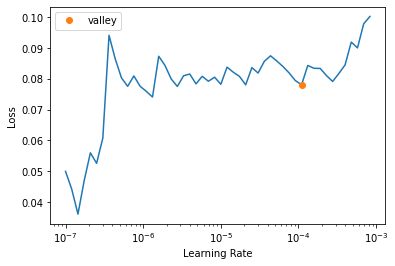

In [8]:
learner.lr_find()

In [ ]:
learner.fine_tune(15, 0.0010000000474974513)

Here I load another learner to tune it in a different manner and try to improve the accuracy further.

In [6]:
learn = vision_learner(dataloader, models.resnet34, metrics=accuracy, path=".")

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [7]:
# Implementing checkpointing to save and restore the best performing model.

early_stop = EarlyStoppingCallback(patience=20)
save_best_model = SaveModelCallback(fname='best_model_resnet34')

learn.fit_one_cycle(50, cbs=[early_stop, save_best_model])

epoch,train_loss,valid_loss,accuracy,time
0,1.949258,0.807225,0.729073,02:49
1,1.091706,0.399809,0.863186,01:33
2,0.659828,0.287267,0.907291,01:38
3,0.459200,0.248725,0.919892,01:33
4,0.329911,0.225378,0.928893,01:35
5,0.263347,0.185744,0.939694,01:34
6,0.210430,0.173159,0.947795,01:35
7,0.191082,0.178035,0.947795,02:37
8,0.152664,0.197098,0.947795,02:37
9,0.137193,0.181733,0.955896,02:37


Better model found at epoch 0 with valid_loss value: 0.8072249293327332.
Better model found at epoch 1 with valid_loss value: 0.3998085558414459.
Better model found at epoch 2 with valid_loss value: 0.28726744651794434.
Better model found at epoch 3 with valid_loss value: 0.2487250715494156.
Better model found at epoch 4 with valid_loss value: 0.2253778874874115.
Better model found at epoch 5 with valid_loss value: 0.18574389815330505.
Better model found at epoch 6 with valid_loss value: 0.17315882444381714.
Better model found at epoch 11 with valid_loss value: 0.1693861335515976.
Better model found at epoch 12 with valid_loss value: 0.16116921603679657.
No improvement since epoch 12: early stopping


##### Loading previous best model to further tune

In [8]:
learn.load('best_model_resnet34')

/opt/conda/lib/python3.7/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Unfreezing the model at this step allows more layers to be tuned and trained to our dataset, which leads to a generally better performance.

In [13]:
learn.unfreeze()

In [11]:
def find_appropriate_lr(model:Learner, lr_diff:int = 15, loss_threshold:float = .05, adjust_value:float = 1, plot:bool = False) -> float:
    model.lr_find()
    
    losses = np.array(model.recorder.losses)
    min_loss_index = np.argmin(losses)
    lrs = model.recorder.lrs
    
    return lrs[min_loss_index] / 10

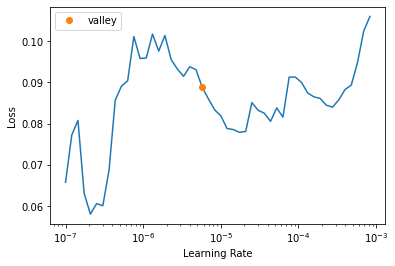

In [14]:
learning_rate = find_appropriate_lr(learn)

In [15]:
learn.fit_one_cycle(50, lr_max=slice(learning_rate/10, learning_rate), cbs=[early_stop, save_best_model])

epoch,train_loss,valid_loss,accuracy,time
0,0.078409,0.160680,0.961296,02:36
1,0.075956,0.162282,0.960396,02:35
2,0.072931,0.163725,0.959496,02:37
3,0.068975,0.163041,0.961296,02:39
4,0.076701,0.164275,0.960396,02:39
5,0.078182,0.161976,0.962196,02:01
6,0.069314,0.163664,0.960396,01:37
7,0.070805,0.163490,0.962196,01:36
8,0.068629,0.159312,0.961296,01:37
9,0.072546,0.166810,0.959496,01:37


Better model found at epoch 0 with valid_loss value: 0.16068001091480255.
Better model found at epoch 8 with valid_loss value: 0.15931178629398346.
Better model found at epoch 10 with valid_loss value: 0.15773774683475494.
No improvement since epoch 10: early stopping


In [16]:
learn.load('best_model_resnet34')

The best model with current tuning has an accuracy of 96.2%, which is pretty good but could definitely be improved on. This could be achieved by further tuning, data augmentation, and such steps. I opt however to train another model which has a generally higher accuracy. That is covered in another notebook, `03_supergradients_model.ipynb` to keep notebook size manageable. 